# Training CNN for imaging fluid flow with streaks analysis
    

## Prepatory steps

Get some includes first and define convenience routines

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import random
import sys

%matplotlib inline

print(torch.__version__)

1.0.1.post2


Fix random seed to make sure we get reproducible results. This can be removed at production stage.

In [2]:
my_seed = 12345
torch.manual_seed(my_seed)

Load data and preprocess

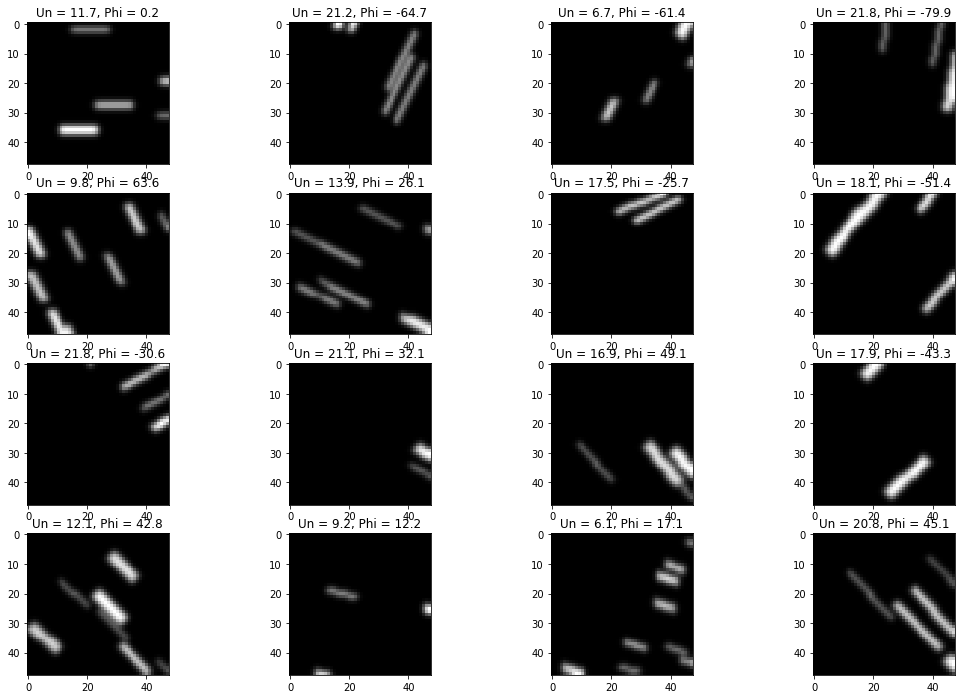

In [3]:
h5f = h5py.File('data/train_val_sets_n=1M.h5','r')

images = h5f['images'][()]
Un = h5f['Un'][()]
Phi = h5f['Phi'][()]
windowSize = h5f['windowSize'][()]

h5f.close()

trainImages, validationImages, trainData, validationData = \
    train_test_split(images, np.column_stack((Un, Phi)), test_size=0.25, random_state=my_seed, shuffle = False)

images = []

indices = random.randint(0, len(trainImages), 16)

fig = plt.figure()
for i in range(indices.size):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.gray()
    plt.imshow(trainImages[indices[i],0,:,:])
    ax.set_title("Un = %.1f, Phi = %.1f" % (trainData[indices[i],0], trainData[indices[i],1]))
    
fig.set_size_inches(np.array(fig.get_size_inches()) * 3)
plt.show()

Preprocess data

((750000, 2), (250000, 2))


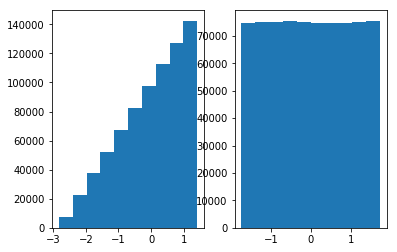

In [4]:
scaler = StandardScaler()
trainDataUnit = scaler.fit_transform(trainData)
validationDataUnit = scaler.transform(validationData)

print((trainDataUnit.shape, validationDataUnit.shape))

fig = plt.figure()
ax = fig.add_subplot(1,2,1)
plt.hist(trainDataUnit[:,0]);
ax = fig.add_subplot(1,2,2)
plt.hist(trainDataUnit[:,1]);

## Creating and training of a CNN

Define some global settings

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


Load network architecture we will use

In [6]:
from CNN_architectures import StreaksCNN

Convert data into pytorch compatible format

In [7]:
params = {'batch_size': 192,
          'shuffle': True,
          'num_workers': 0}

xtrain = torch.from_numpy(trainImages / 255.).type(torch.FloatTensor)
ytrain = torch.from_numpy(trainDataUnit).type(torch.FloatTensor)

train_dataset = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(train_dataset, **params)

#for batch_idx, (x, y) in enumerate(train_loader):
#    print(x.shape, y.shape)

xvalidation = torch.from_numpy(validationImages / 255.).type(torch.FloatTensor)
yvalidation = torch.from_numpy(validationDataUnit).type(torch.FloatTensor)

validation_dataset = TensorDataset(xvalidation, yvalidation)
validation_loader = DataLoader(validation_dataset, **params)

print(len(train_dataset), len(validation_dataset))

750000 250000


Perform training

In [ ]:
learning_rate = 1e-3

net = StreaksCNN(winSz = windowSize, filtSz = 5, convPad = 2)
net.to(device)
loss = torch.nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', \
                                                 factor = 0.5, patience = 7, \
                                                 min_lr = 1e-5, verbose = True, \
                                                 threshold = 1e-3)

n_epochs = 150
n_batches = len(train_loader)

# Time for printing
training_start_time = time.time()

train_loss_log = np.zeros(n_epochs)
validation_loss_log = np.zeros(n_epochs)

# Loop for n_epochs
for epoch in range(n_epochs):
    total_train_loss = 0
        
    start_time = time.time()
    net.train()
    for i, data in enumerate(train_loader, 0):
        # Get inputs
        inputs, outputs = data
            
        # Send them to GPU
        inputs, outputs = inputs.to(device), outputs.to(device)
                
        # Set the parameter gradients to zero
        optimizer.zero_grad()
            
        # Forward pass, backward pass, optimize
        net_outputs = net(inputs)
        
        loss_size = loss(net_outputs, outputs)
        loss_size.backward()
        optimizer.step()
            
        #total_train_loss += loss_size.item()

        # Reset time
        start_time = time.time()

    # At the end of the epoch, do a pass on the training set to get true loss
    net.eval()
    total_train_loss = 0
    for inputs, outputs in train_loader:
        # Send to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # Forward pass
        net_outputs = net(inputs)
        net_loss_size = loss(net_outputs, outputs)
        total_train_loss += net_loss_size.item()
        
    # At the end of the epoch, do a pass on the validation set
    net.eval()
    total_val_loss = 0
    for inputs, outputs in validation_loader:
        # Send to device
        inputs, outputs = inputs.to(device), outputs.to(device)

        # Forward pass
        val_outputs = net(inputs)
        val_loss_size = loss(val_outputs, outputs)
        total_val_loss += val_loss_size.item()
        
    scheduler.step(total_val_loss)
    sys.stdout.flush()
    
    train_loss_log[epoch] = np.sqrt(total_train_loss / len(train_dataset))
    validation_loss_log[epoch] = np.sqrt(total_val_loss / len(validation_dataset))
    
    print("Epoch {:}. Train RMSE = {:.4f}, Validation RMSE = {:.4f}".format(epoch, train_loss_log[epoch], validation_loss_log[epoch]))

print("Training finished, took {:.1f}s".format(time.time() - training_start_time))

Epoch 0. Train RMSE = 0.3323, Validation RMSE = 0.3368
Epoch 1. Train RMSE = 0.3303, Validation RMSE = 0.3355
Epoch 2. Train RMSE = 0.2979, Validation RMSE = 0.3031
Epoch 3. Train RMSE = 0.2934, Validation RMSE = 0.2995
Epoch 4. Train RMSE = 0.2817, Validation RMSE = 0.2885
Epoch 5. Train RMSE = 0.2770, Validation RMSE = 0.2835
Epoch 6. Train RMSE = 0.2749, Validation RMSE = 0.2817
Epoch 7. Train RMSE = 0.2964, Validation RMSE = 0.3035
Epoch 8. Train RMSE = 0.2702, Validation RMSE = 0.2783
Epoch 9. Train RMSE = 0.2720, Validation RMSE = 0.2807
Epoch 10. Train RMSE = 0.2769, Validation RMSE = 0.2858
Epoch 11. Train RMSE = 0.2607, Validation RMSE = 0.2706
Epoch 12. Train RMSE = 0.2564, Validation RMSE = 0.2656
Epoch 13. Train RMSE = 0.2592, Validation RMSE = 0.2690
Epoch 14. Train RMSE = 0.2630, Validation RMSE = 0.2728
Epoch 15. Train RMSE = 0.2512, Validation RMSE = 0.2621
Epoch 16. Train RMSE = 0.2521, Validation RMSE = 0.2631
Epoch 17. Train RMSE = 0.2592, Validation RMSE = 0.2712
Ep

Once the network is trained, let us display some learning statistics and model information

In [ ]:
fig = plt.figure()
plt.plot(train_loss_log, '')
plt.plot(validation_loss_log)
plt.legend(('Train', 'Validation'))
plt.xlabel('Epoch')
plt.ylabel('RMSE')

Print model summary

In [ ]:
print(net)

Apply final network to the validation data set and check accuracy on Un and phi independently

In [ ]:
params = {'batch_size': 192,
          'shuffle': False,
          'num_workers': 0}

test_loader = DataLoader(validation_dataset, **params)

ypredicted = np.empty(shape=(0,2))

net.eval()
for inputs, outputs in test_loader:
    # Wrap tensors in Variables
    inputs, outputs = inputs.to(device), outputs.to(device)
            
    # Forward pass
    val_outputs = net(inputs)
    
    if 'cuda' in device.type:
        val_outputs = val_outputs.cpu()
    
    ypredicted = np.concatenate((ypredicted, val_outputs.data.numpy()))
    
ypredicted = scaler.inverse_transform(ypredicted)
yresiduals = ypredicted - validationData
yrmse = np.sqrt(np.mean(yresiduals**2, axis = 0))

print('RMSE on Un = ', yrmse[0], ', RMSE on phi = ', yrmse[1])

thrNorm = 2;
thrPhi = 18; 
numCorrectNorm = np.sum(np.abs(yresiduals[:,0]) < thrNorm)
numCorrectPhi = np.sum(np.abs(yresiduals[:,1]) < thrPhi)

accuracy = np.array([numCorrectNorm, numCorrectPhi])/len(yresiduals)
print(accuracy)

Save trained network and all additional training data

In [ ]:
file_net = 'network_n=1M'

torch.save(net.state_dict(), ('networks/%s.pytorch' % file_net))

h5f = h5py.File(('networks/%s_data.h5' % file_net), 'w')
h5f.create_dataset('RMSE', data=yrmse, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainImages', data=trainImages, compression="gzip", compression_opts=6)
h5f.create_dataset('validationImages', data=validationImages, compression="gzip", compression_opts=6)
#h5f.create_dataset('trainData', data=trainData)
h5f.create_dataset('validationData', data=validationData)
h5f.create_dataset('scale', data=scaler.scale_)
h5f.create_dataset('mean', data=scaler.mean_)
h5f.create_dataset('rmse_training', data=train_loss_log)
h5f.create_dataset('rmse_validation', data=validation_loss_log)
h5f.create_dataset('windowSize', data=windowSize)

h5f.close()